<font size="6">Timeseries Extraction</font>
 
 <font size="3">To demonstrate timeseries extraction using the `TimeseriesExtractor` class, the single subject dataset used to test the neurocaps package will be downloaded for demonstration. For the timeseries extraction to work, the pybids package must be installed. To install pybids on Windows, you can use `pip install pybids`
 or `pip install neurocaps[windows]`. Additionally, for pybids installation on Windows, you may need to enable long path support. The instructions to do so, involves right clicking on Powershell, selecting "Run as Administrator", and pasting in the Powershell command located in the official [Microsoft documentation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell). An alternative involves installing [Windows Subsytem for Linux (WSL)](https://code.visualstudio.com/docs/remote/wsl-tutorial) and [opening jupyter notebook from the Ubuntu terminal](https://saturncloud.io/blog/how-to-install-jupyter-notebook-in-ubuntu/). </font>

Downloading data from OpenNeuro, requires `pip install openneuro-py ipywidgets` or `pip install neurocaps[demo]`. **Note:** Ensure that the "neurocaps_demo" folder is populated before proceeding regardless if the code completes execution. If it is empty, then the contents are still being donwloaded.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
import plotly.io as pio, joblib

# To show static plotly images so that they can be displayed on the saved Jupyter notebook on Github
pio.renderers.default = "svg"

from openneuro import download

demo_dir = "neurocaps_demo"
os.makedirs(demo_dir, exist_ok=True)

# Include the run-1 data and derivatives of two tasks for two subjects
include = [
    "dataset_description.json",
    "sub-0004/ses-2/func/*run-[12]*events*",
    "sub-0006/ses-2/func/*run-[12]*events*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]_space-MNI152NLin*brain_mask*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]_space-MNI152NLin*brain_mask*",
]

download(
    dataset="ds005381",
    include=include,
    target_dir=demo_dir,
    verify_hash=False,
)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds005381 …


📁 Traversing directories for ds005381 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 57 files (5 concurrent downloads). 
✅ Finished downloading ds005381.
 
🧠 Please enjoy your brains.
 


The first level of the fmriprep directory must also have a *"dataset_description.json"* file.

In [2]:
import json

desc = {
    "Name": "fMRIPrep - fMRI PREProcessing workflow",
    "BIDSVersion": "1.0.0",
    "DatasetType": "derivative",
    "GeneratedBy": [{"Name": "fMRIPrep", "Version": "20.2.0", "CodeURL": "https://github.com/nipreps/fmriprep"}],
}

with open("neurocaps_demo/derivatives/fmriprep/dataset_description.json", "w", encoding="utf-8") as f:
    json.dump(desc, f)

Perform timeseries extraction.

In [3]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts

# Setting parcel_approach
parcel_approach = {"Schaefer": {"n_rois": 100}}
# parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = (
    parcel_approach["Schaefer"]["n_rois"]
    if "Schaefer" in parcel_approach.keys()
    else (116 if parcel_approach["AAL"]["version"] != "3v2" else 166)
)

confound_names = [
    "cosine*",
    "trans_x",
    "trans_x_derivative1",
    "trans_y",
    "trans_y_derivative1",
    "trans_z",
    "trans_z_derivative1",
    "rot_x",
    "rot_x_derivative1",
    "rot_y",
    "rot_y_derivative1",
    "rot_z",
    "rot_z_derivative1",
]

# Set up signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin6Asym",
    parcel_approach=parcel_approach,
    standardize="zscore_sample",
    use_confounds=True,
    confound_names=confound_names,
    detrend=True,
    low_pass=0.15,
    high_pass=None,
    n_acompcor_separate=2,  # First n acompcor of the WM and CSF masks
    dummy_scans={"auto": True, "min": 5},
    fd_threshold={"threshold": 0.5, "outlier_percentage": 0.30},
)

# Perform the timeseries extraction; only one session can be extracted at a time. Internally, @cache (or @lru_cache in
# > 18.3) is used so that pybids only needs to be query once for every unique `bids_dir` and `pipeline_name`
# combination per session. ``TimeseriesExtractor.get_bold().clear()`` (or ``TimeseriesExtractor._call_layout.cache_clear()``
# in > 18.3) can be used to clear the cache. Use `n_cores` to speed up extraction

# May need to clear cache if the cell was ran before the directory download completed
try:
    TimeseriesExtractor._call_layout.cache_clear()
except:
    pass

extractor.get_bold(
    bids_dir="neurocaps_demo",
    session="2",
    task="DET",
    condition="late",
    condition_tr_shift=2,
    slice_time_ref=1,
    n_cores=None,
    flush=True,
    tr=2,
    verbose=True,
    progress_bar=True,  # Parameter available in versions >= 0.21.5
)

2025-02-18 01:26:10,514 neurocaps._utils.check_parcel_approach [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2025-02-18 01:26:10,514 neurocaps._utils.check_parcel_approach [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.
2025-02-18 01:26:10,520 neurocaps._utils.extraction.check_confound_names [INFO] Confound regressors to be used if available: cosine*, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1.
2025-02-18 01:26:12,062 neurocaps.extraction.timeseriesextractor [INFO] BIDS Layout: ...neurocaps\demos\neurocaps_demo | Subjects: 2 | Sessions: 2 | Runs: 4


Processing Subjects:   0%|          | 0/2 [00:00<?, ?it/s]

2025-02-18 01:26:12,243 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] Preparing for Timeseries Extraction using [FILE: sub-0004_ses-2_task-DET_run-1_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz].
2025-02-18 01:26:12,263 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] Default dummy scans set by 'min' will be used: 5.
2025-02-18 01:26:12,278 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] The following confounds will be used for nuisance regression: cosine00, cosine01, cosine02, cosine03, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_33, a_comp_cor_34.
2025-02-18 01:26:22,867 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION

In [4]:
# Print metadata
print(extractor)

Metadata:
Preprocessed Bold Template Space                           : MNI152NLin6Asym
Parcellation Approach                                      : Schaefer
Signal Clean Info                                          : {'masker_init': {'standardize': 'zscore_sample', 'detrend': True, 'low_pass': 0.15, 'high_pass': None, 'smoothing_fwhm': None}, 'dummy_scans': {'auto': True, 'min': 5}, 'n_acompcor_separate': 2, 'fd_threshold': {'threshold': 0.5, 'outlier_percentage': 0.3}, 'use_confounds': True, 'dtype': None, 'confound_names': ['cosine*', 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z', 'rot_z_derivative1']}
Task Info                                                  : {'task': 'DET', 'session': '2', 'runs': None, 'condition': 'late', 'condition_tr_shift': 2, 'tr': 2, 'slice_time_ref': 1}
Number of Subjects                                         : 2
CPU Cores Used fo

In [5]:
import neurocaps

neurocaps.__version__

'0.22.1'

<font size="6">BOLD Visualization</font>

<font size="3">Visualizing bold data using the `self.visualize_bold` method.</font>

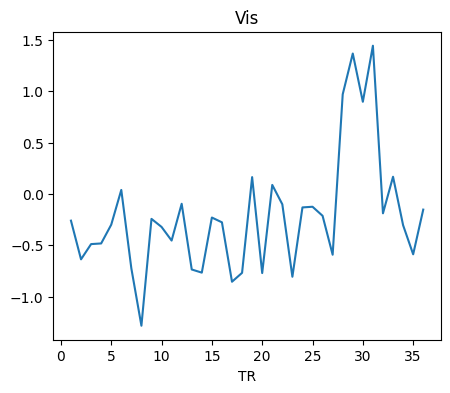

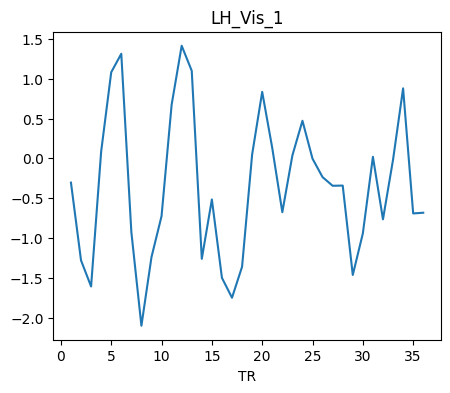

In [6]:
if "AAL" in parcel_approach:
    extractor.visualize_bold(subj_id="0004", run="1", region="Precentral", figsize=(5, 4))

    extractor.visualize_bold(subj_id="0004", run="1", roi_indx=0, figsize=(5, 4))
else:
    extractor.visualize_bold(subj_id="0004", run="1", region="Vis", figsize=(5, 4))

    extractor.visualize_bold(subj_id="0004", run="1", roi_indx="LH_Vis_1", figsize=(5, 4))

 <font size="6">Saving Timeseries as Pickle</font>
 
 <font size="3">`self.get_bold` produces a nested dictionary structure containing the subject id, run id, and the associated timeseries data. This nested dictionary is stored in the `self.subject_timeseries` attribute and can be saved as a pickle file using `self.timeseries_to_pickle`.</font>

In [7]:
output_dir = "neurocaps_demo/neurocaps_outputs"
extractor.timeseries_to_pickle(output_dir=output_dir, filename="DET_timeseries.pkl")

 <font size="6">Co-Activation Patterns (CAPs) With No Groups</font>
 
 <font size="3">Initializing the `CAP` class and using the saved pickle file as input for `self.get_caps`.  When group is `None`, which is the default value of this parameter, then the default group name is "All Subjects".</font>

2025-02-18 01:26:55,689 neurocaps.analysis.cap [INFO] [GROUP: All Subjects | METHOD: davies_bouldin] Optimal cluster size is 2.


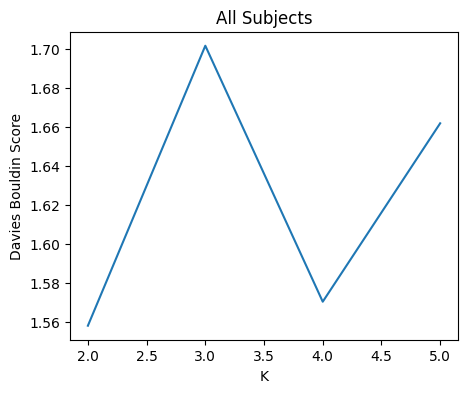

In [8]:
# `parcel_approach` is only required for certain visualization functions and can be set later
# cap_analysis = CAP(parcel_approach = {"Schaefer": {"n_rois": 100}})

cap_analysis = CAP(extractor.parcel_approach, groups=None)

cap_analysis.get_caps(
    subject_timeseries=f"{output_dir}/DET_timeseries.pkl",
    n_clusters=range(2, 6),  # Test k=2 to k=5
    standardize=True,
    cluster_selection_method="davies_bouldin",
    show_figs=True,
    figsize=(5, 4),
)

In [9]:
# Print metadata
print(cap_analysis)

Metadata:
Parcellation Approach                           : Schaefer
Groups                                          : All Subjects
N Clusters                                      : [2, 3, 4, 5]
Cluster Selection Method                        : davies_bouldin
CPU Cores Used for Clustering (Multiprocessing) : None
User-Specified Runs IDs Used for Clustering     : None
Standardize                                     : True
Concatenated Timeseries Bytes                   : 104184 bytes
CAPs                                            : {'All Subjects': 2}
Optimal N Clusters                              : {'All Subjects': 2}
Variance Explained by Clustering                : {'All Subjects': np.float64(0.2404156107478499)}



 <font size="6">Calculating CAP Metrics With No Groups</font>

 <font size="3">Getting CAP metrics using the `self.calculate_metrics` method. Available metrics includes "counts", "temporal_fraction", "persistence", "transition_frequency", and "transition_probability".</font>

In [10]:
# Get metric for the subjects in the `subject_timeseries` pickle file
cap_analysis.calculate_metrics(subject_timeseries=f"{output_dir}/DET_timeseries.pkl", metrics="persistence")[
    "persistence"
]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0004,All Subjects,run-1,4.666667,1.600000
1,0004,All Subjects,run-2,3.400000,2.250000
2,0006,All Subjects,run-1,2.875000,1.555556
3,0006,All Subjects,run-2,2.571429,1.857143


 <font size="6">Co-Activation Patterns (CAPs) With Groups</font>
 
 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes). For demonstration purposes, a simulated `subject_timeseries` is created.</font>

2025-02-18 01:26:55,889 neurocaps._utils.check_parcel_approach [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2025-02-18 01:26:55,889 neurocaps._utils.check_parcel_approach [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.
2025-02-18 01:26:59,841 neurocaps.analysis.cap [INFO] [GROUP: A | METHOD: silhouette] Optimal cluster size is 3.


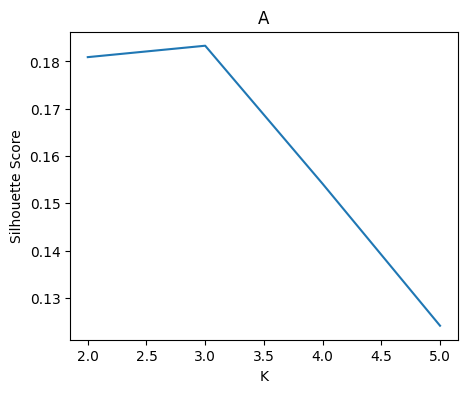

2025-02-18 01:26:59,956 neurocaps.analysis.cap [INFO] [GROUP: B | METHOD: silhouette] Optimal cluster size is 2.


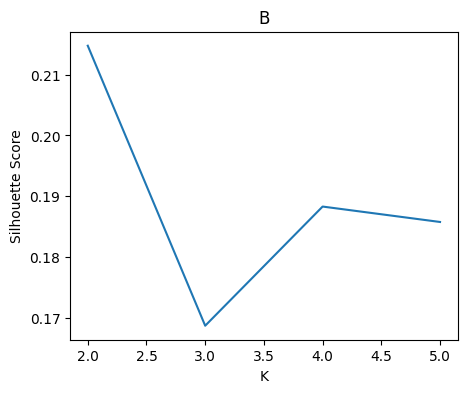

In [11]:
# Initializing CAP class and performing the elbow method
cap_analysis = CAP(groups={"A": ["0004"], "B": ["0006"]})

# Setting parcel approach instead of assigning it during initialization of the CAP class
cap_analysis.parcel_approach = parcel_approach

cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    n_clusters=range(2, 6),
    cluster_selection_method="silhouette",
    n_cores=2,  # Used when `n_clusters` is a list, to run multiple kmeans simultaneously
    show_figs=True,
    figsize=(5, 4),
)

In [12]:
# Print metadata
print(cap_analysis)

Metadata:
Parcellation Approach                           : Schaefer
Groups                                          : A, B
N Clusters                                      : [2, 3, 4, 5]
Cluster Selection Method                        : silhouette
CPU Cores Used for Clustering (Multiprocessing) : 2
User-Specified Runs IDs Used for Clustering     : None
Standardize                                     : True
Concatenated Timeseries Bytes                   : 104184 bytes
CAPs                                            : {'A': 3, 'B': 2}
Optimal N Clusters                              : {'A': 3, 'B': 2}
Variance Explained by Clustering                : {'A': np.float64(0.3770039254296592), 'B': np.float64(0.24374732750804962)}



<font size="6">Calculating CAPs Metrics With Groups</font>

 <font size="3">Note, all groups are in the same dataframe for simplicity purposes (except for "transition_probability" where each group has separate dataframes) but use their own kmeans models to calculate each metric. Consequently, "CAP-1" and "CAP-2" are different for each group. In cases where the optimal cluster size for each group differs, values assigned as NaN is just indicates that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject.</font>

In [13]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0004,A,run-1,0.277778,0.611111,0.111111
1,0004,A,run-2,0.307692,0.576923,0.115385
2,0006,B,run-1,0.324324,0.675676,NaN
3,0006,B,run-2,0.354839,0.645161,NaN


In [14]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0004,A,run-1,8,8,1.0
1,0004,A,run-2,5,8,2.0
2,0006,B,run-1,6,7,NaN
3,0006,B,run-2,8,8,NaN


 <font size="6">Calculating CAP Metrics and Treating Separate Runs as Continuous Runs </font>

In [15]:
metrics = cap_analysis.calculate_metrics(
    subject_timeseries=extractor.subject_timeseries, metrics="transition_probability", continuous_runs=True
)

metrics["transition_probability"]["A"]

,Subject_ID,Group,Run,1.1,1.2,1.3,2.1,2.2,2.3,3.1,3.2,3.3
0,0004,A,run-continuous,0.277778,0.666667,0.055556,0.333333,0.611111,0.055556,0.0,0.428571,0.571429


  <font size="6">Transition Probability Matrix</font>
  
 <font size="3">`transition_matrix` can be used to generate and visualize the averaged transition probabilities for each group. </font>

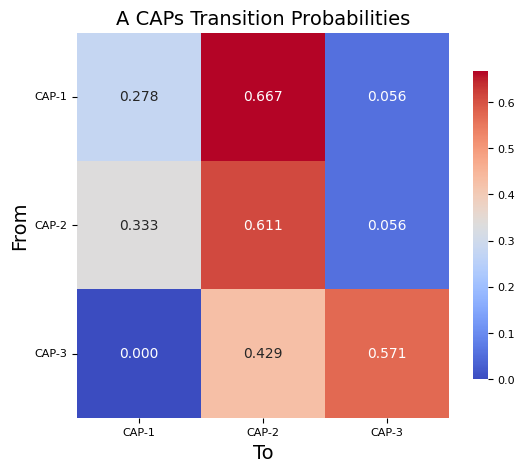

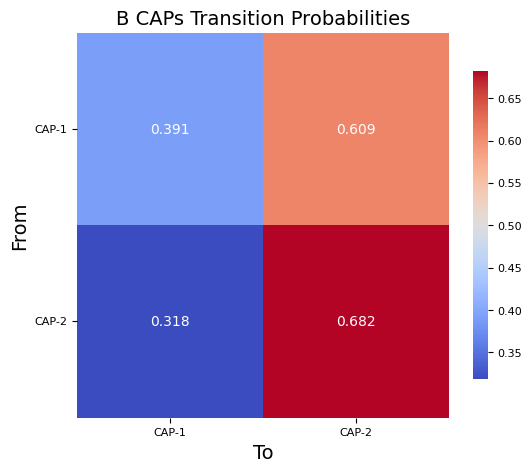

,CAP-1,CAP-2
From/To,,
CAP-1,0.391304,0.608696
CAP-2,0.318182,0.681818


In [16]:
from neurocaps.analysis import transition_matrix

trans_df = transition_matrix(
    trans_dict=metrics["transition_probability"], annot=True, fmt=".3f", return_df=True, figsize=(6, 5), show_figs=True
)

trans_df["B"]

<font size="6">Plotting CAPs as Outer Products and Heatmaps </font>

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `self.caps2plot` method.</font>

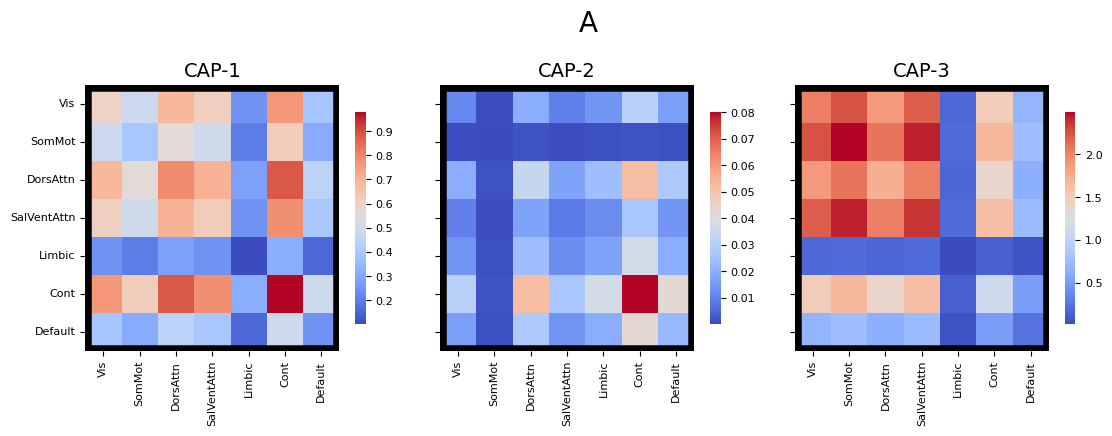

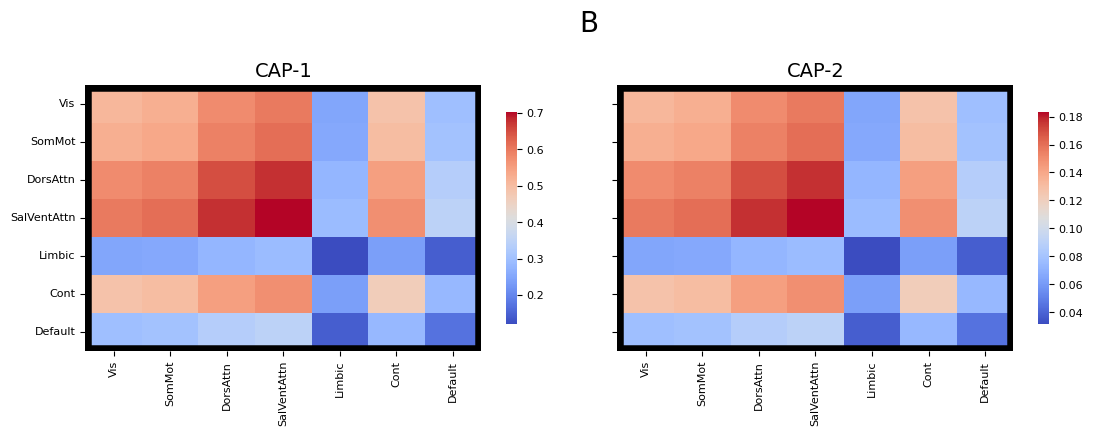

In [17]:
cap_analysis.caps2plot(
    subplots=True, xlabel_rotation=90, sharey=True, borderwidths=9, figsize=(11, 4), tight_layout=True
)

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `self.caps2plot` method.</font>

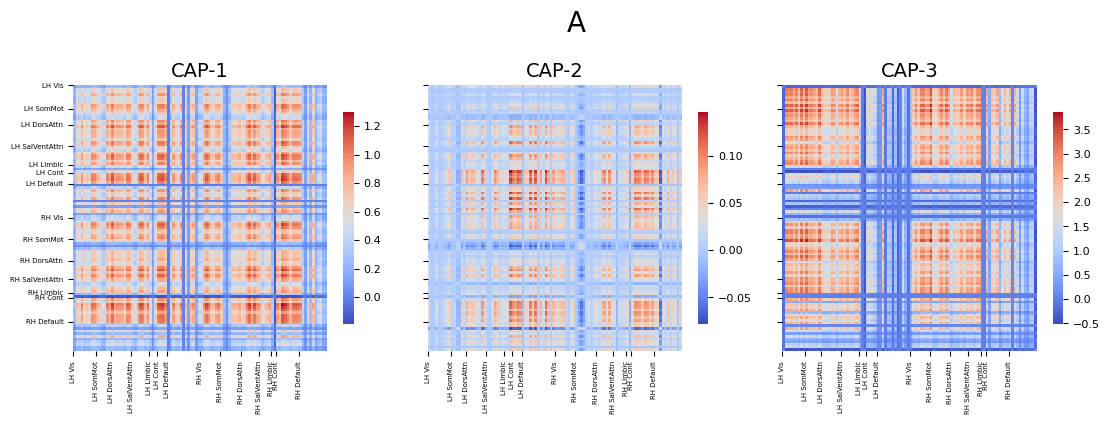

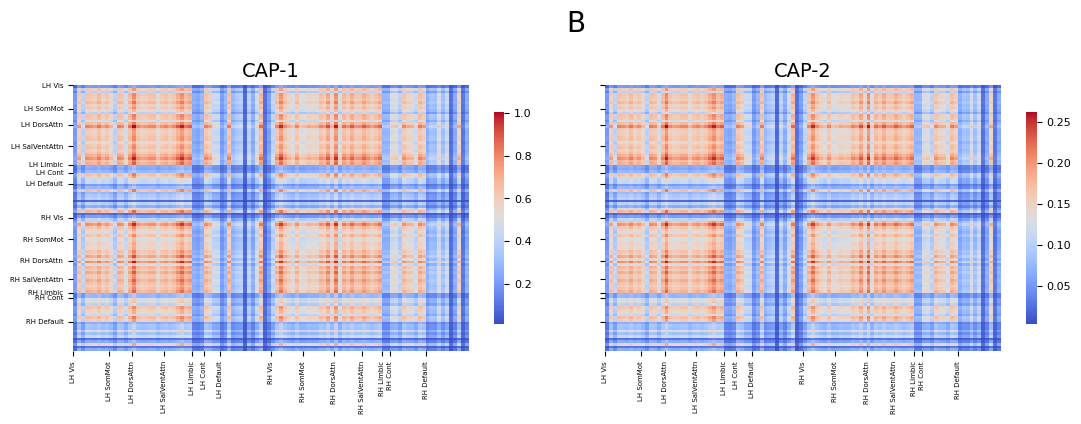

In [18]:
cap_analysis.caps2plot(
    yticklabels_size=5,
    wspace=0.1,
    subplots=True,
    visual_scope="nodes",
    xlabel_rotation=90,
    xticklabels_size=5,
    hspace=0.6,
    tight_layout=True,
    figsize=(11, 4),
)

 <font size="3">Visualizing CAPs as heatmaps at the regional level and using the `hemishere_labels` parameter to label the left and right hemispheres using `self.caps2plot` method.</font>

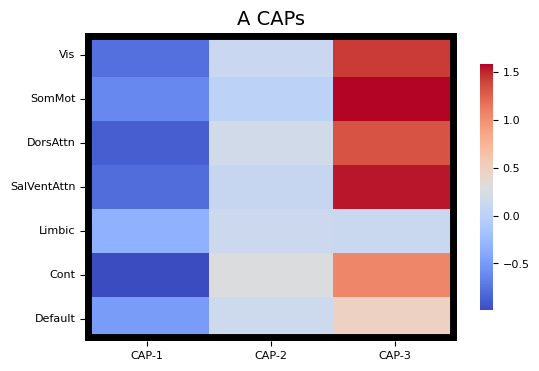

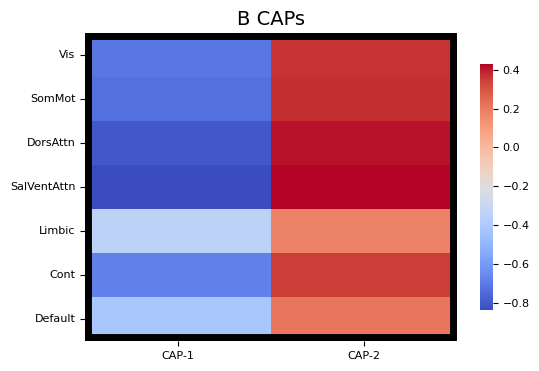

In [19]:
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10, figsize=(6, 4))

 <font size="6">Merging Different Timeseries Across Sessions or Tasks </font>

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `self.calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [20]:
# Extract the Retino data
extractor.get_bold(bids_dir="neurocaps_demo", task="Retino", tr=2, condition_tr_shift=2, slice_time_ref=1)

extractor.timeseries_to_pickle(output_dir=output_dir, filename="Retino_timeseries.pkl")

2025-02-18 01:27:02,467 neurocaps.extraction.timeseriesextractor [WARNING] `condition_tr_shift` specified but `condition` is None.
2025-02-18 01:27:02,467 neurocaps.extraction.timeseriesextractor [WARNING] `slice_time_ref` specified but `condition` is None.
2025-02-18 01:27:02,765 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 1] Preparing for Timeseries Extraction using [FILE: sub-0004_ses-2_task-Retino_run-1_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz].
2025-02-18 01:27:02,782 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 1] Default dummy scans set by 'min' will be used: 5.
2025-02-18 01:27:02,786 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 1] The following confounds will be used for nuisance regression: cosine00, cosine01, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_der

In [21]:
# Returns merged dictionary as well as the reduced subject dictionaries containing only the subjects present in the merged
all_dicts = merge_dicts(
    subject_timeseries_list=[f"{output_dir}/DET_timeseries.pkl", f"{output_dir}/Retino_timeseries.pkl"],
    return_merged_dict=True,
    return_reduced_dicts=True,
)

 <font size="6">Identifying CAPs in Merged Timeseries </font>

 <font size="3">Generating examples not using the `group` parameter. Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group. The merged timeseries in `all_dicts` which was generated in the previous cell will be used as input here.</font>

In [22]:
cap_analysis = CAP(parcel_approach={"Schaefer": {"n_rois": 100, "resolution_mm": 1, "yeo_networks": 7}})

cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

 <font size="6">Calculating CAP Metrics on Subsets of Merged Timeseries </font>

In [23]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_0"], return_df=True, runs=[1, 2])

output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0004,All Subjects,run-1,0.250000,0.277778,0.472222
1,0004,All Subjects,run-2,0.384615,0.192308,0.423077
2,0006,All Subjects,run-1,0.432432,0.297297,0.270270
3,0006,All Subjects,run-2,0.516129,0.064516,0.419355


In [24]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2], continuous_runs=True
)

output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0004,All Subjects,run-continuous,2.400000,1.458333,2.34375
1,0006,All Subjects,run-continuous,3.166667,2.450000,3.00000


In [25]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2])

output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,0004,All Subjects,run-1,47
1,0004,All Subjects,run-2,42
2,0006,All Subjects,run-1,31
3,0006,All Subjects,run-2,30


<font size="6">CAPs Pearson Correlation Matrix </font>

 <font size="3">`self.caps2corr` can be used to obtain the Pearson correlation between CAPs and to obtain a dataframe of the uncorrected p-values.</font>

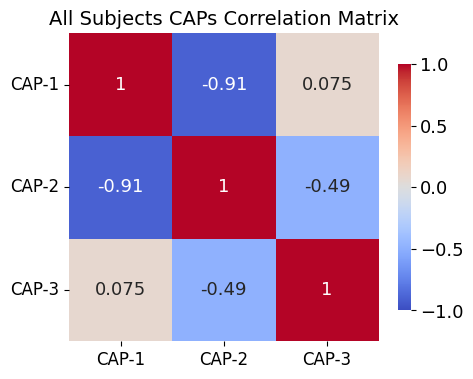

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.91 (2.1e-38)***,0.075 (0.46)
CAP-2,-0.91 (2.1e-38)***,1 (0)***,-0.49 (2.3e-07)***
CAP-3,0.075 (0.46),-0.49 (2.3e-07)***,1 (0)***


In [26]:
corr_df = cap_analysis.caps2corr(
    annot=True,
    figsize=(5, 4),
    xticklabels_size=12,
    yticklabels_size=12,
    return_df=True,
    vmin=-1,
    vmax=1,
    annot_kws={"size": 13},
    cbarlabels_size=13,
)

corr_df["All Subjects"]

 <font size="6">CAPs Surface Plots </font> 
 
 <font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

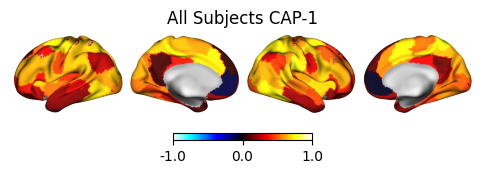

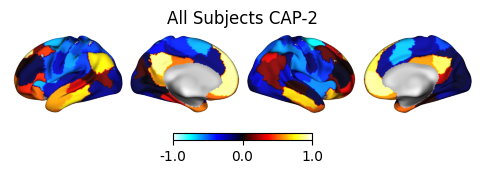

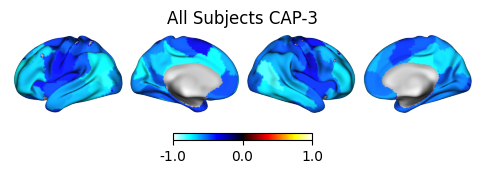

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

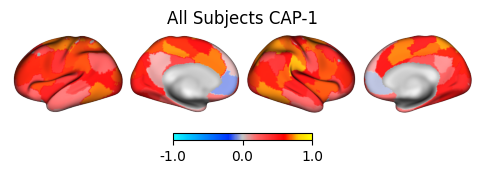

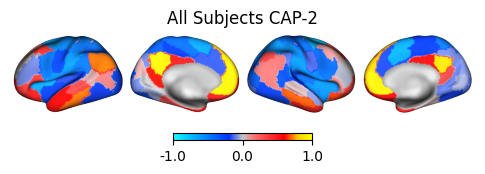

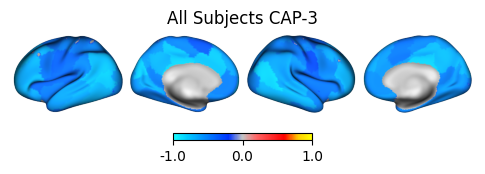

In [27]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

cap_analysis.caps2surf(cmap="cold_hot", layout="row", color_range=(-1, 1), size=(500, 100))

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

cap_analysis.caps2surf(
    cmap=custom_cmap, size=(500, 100), color_range=(-1, 1), layout="row", surface="veryinflated", progress_bar=True
)

 <font size="6">CAPs to NifTIs </font>

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `self.caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [28]:
cap_analysis.caps2niftis(output_dir=output_dir, suffix_filename="for_neurocaps_demo", progress_bar=True)

Generating Statistical Maps [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

<font size="6">CAPs to Radar Plots </font>

 <font size="3">Radar plots showing the cosine similarity between each network and the positive ("High Amplitude") and negative ("Low Amplitude") activations in each CAP. Since this function assumes that the matrix subjected to kmeans clustering was standardized, "High Amplitude" represents values above the mean (0) and "Low Amplitude" represents values below the mean (0). During calculation of the "Low Amplitude" cosine similarity, the inverse is computed to turn this similarity positive for visualization purposes.</font>

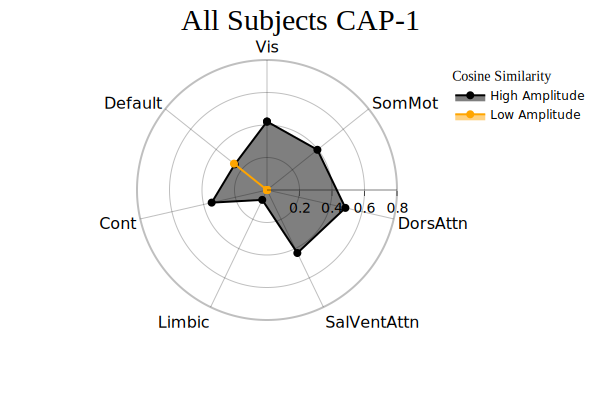

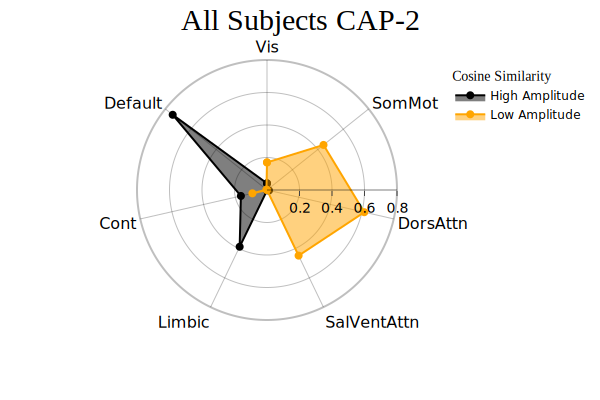

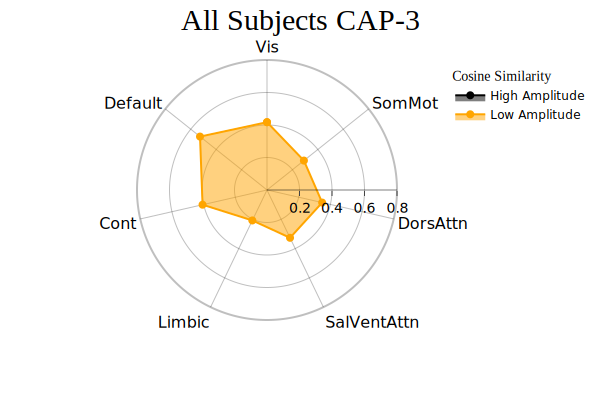

In [29]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.8],
    "tickvals": ["", 0.2, "", 0.4, "", 0.6, "", 0.8],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "black", "Low Amplitude": "orange"}

cap_analysis.caps2radar(
    radialaxis=radialaxis, fill="toself", height=400, width=600, color_discrete_map=colors, legend=legend
)

 <font size="3">The cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [30]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])

df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]

print(df)

   High Amplitude  Low Amplitude      Regions
0        0.421181       0.000000          Vis
1        0.396702       0.000000       SomMot
2        0.494921       0.000000     DorsAttn
3        0.430458       0.000000  SalVentAttn
4        0.067498       0.000000       Limbic
5        0.349212       0.000000         Cont
6        0.253431       0.260057      Default


  <font size="6">Using Custom Parcellations </font>

 <font size="3">The neurocaps package uses nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. Neurocaps can also accept additional parcellations (as long as they are lateralized since the current iteration of the codebase assumes an "lh" and "rh" key for each region but this may be changed in a future update. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.</font>

In [31]:
import subprocess, sys

# First, retrieve the map and labels from wayalan Github
output_dir = "neurocaps_demo/figures"
os.makedirs(output_dir, exist_ok=True)

if sys.platform != "win32":
    cmd = [
        ["wget", "-q", "-P", output_dir, "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt"],
        ["wget", "-q", "-P", output_dir, "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz"],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\HCPex_LookUpTable.txt",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\HCPex.nii.gz",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

# Creating custom parcel approach dictionary
parcel_approach = {"Custom": {}}

# Setting the "maps"; this is needed for `TimeseriesExtractore.get_bold()` and `CAP.caps2niftis` and `CAP.cap2surf`
parcel_approach["Custom"]["maps"] = os.path.join(output_dir, "HCPex.nii.gz")

# Setting the "nodes"; needed for "TimeseriesExtractor.visualize_bold"; Getting nodes that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(
    os.path.join(output_dir, "HCPex_LookUpTable.txt"),
    sep=None,
    engine="python",
)["Label"].values[1:]

# Needed for many plotting methods; Setting the region names and their corresponding indices in the nodes list, in this case it is just the label id - 1
parcel_approach["Custom"]["regions"] = {
    "Primary Visual": {"lh": [0], "rh": [180]},
    "Early Visual": {"lh": [1, 2, 3], "rh": [181, 182, 183]},
    "Dorsal Stream Visual": {"lh": range(4, 10), "rh": range(184, 190)},
    "Ventral Stream Visual": {"lh": range(10, 17), "rh": range(190, 197)},
    "MT+ Complex": {"lh": range(17, 26), "rh": range(197, 206)},
    "SomaSens Motor": {"lh": range(26, 31), "rh": range(206, 211)},
    "ParaCentral MidCing": {"lh": range(31, 40), "rh": range(211, 220)},
    "Premotor": {"lh": range(40, 47), "rh": range(220, 227)},
    "Posterior Opercular": {"lh": range(47, 52), "rh": range(227, 232)},
    "Early Auditory": {"lh": range(52, 59), "rh": range(232, 239)},
    "Auditory Association": {"lh": range(59, 67), "rh": range(239, 247)},
    "Insula FrontalOperc": {"lh": range(67, 79), "rh": range(247, 259)},
    "Medial Temporal": {"lh": range(79, 87), "rh": range(259, 267)},
    "Lateral Temporal": {"lh": range(87, 95), "rh": range(267, 275)},
    "TPO": {"lh": range(95, 100), "rh": range(275, 280)},
    "Superior Parietal": {"lh": range(100, 110), "rh": range(280, 290)},
    "Inferior Parietal": {"lh": range(110, 120), "rh": range(290, 300)},
    "Posterior Cingulate": {"lh": range(120, 133), "rh": range(300, 313)},
    "AntCing MedPFC": {"lh": range(133, 149), "rh": range(313, 329)},
    "OrbPolaFrontal": {"lh": range(149, 158), "rh": range(329, 338)},
    "Inferior Frontal": {"lh": range(158, 167), "rh": range(338, 347)},
    "Dorsolateral Prefrontal": {"lh": range(167, 180), "rh": range(347, 360)},
    "Subcortical Regions": {"lh": range(360, 393), "rh": range(393, 426)},
}

# Saving the dictionary as a pickle file
with open(os.path.join(output_dir, "HCPex_dict.pkl"), "wb") as f:
    joblib.dump(parcel_approach, f)

In [32]:
extractor.parcel_approach = os.path.join(output_dir, "HCPex_dict.pkl")

extractor.get_bold(bids_dir="neurocaps_demo", session="2", task="DET", n_cores=2, tr=2, verbose=False)

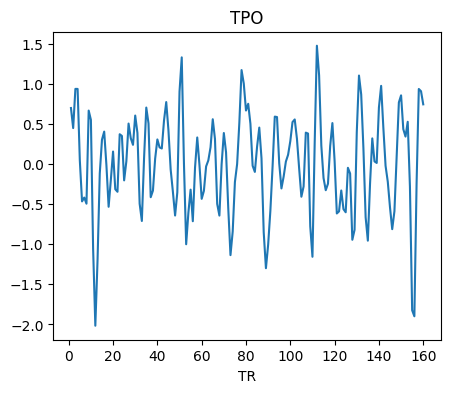

In [33]:
extractor.visualize_bold(subj_id="0006", run=1, region="TPO", figsize=(5, 4))

<font size="3">For "Custom" parcel approaches, all visualization methods can be used.

2025-02-18 01:28:18,362 neurocaps.analysis.cap [INFO] [GROUP: All Subjects | METHOD: elbow] Optimal cluster size is 5.


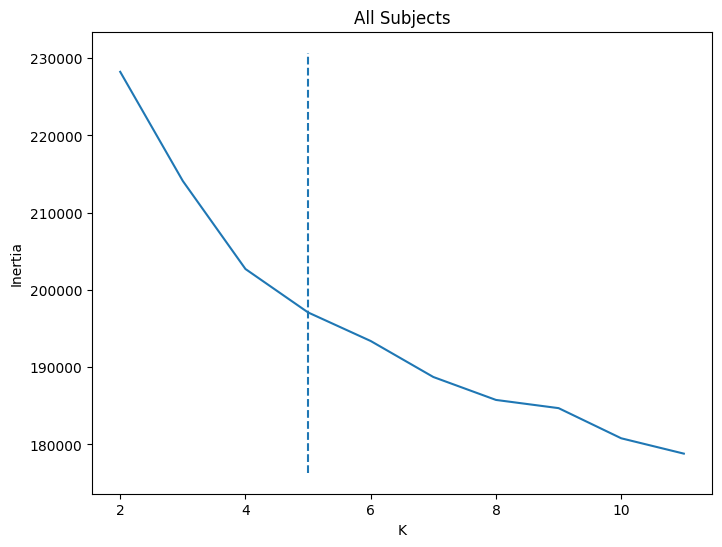

In [34]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)

cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    cluster_selection_method="elbow",
    show_figs=True,
    n_clusters=range(2, 12),
)

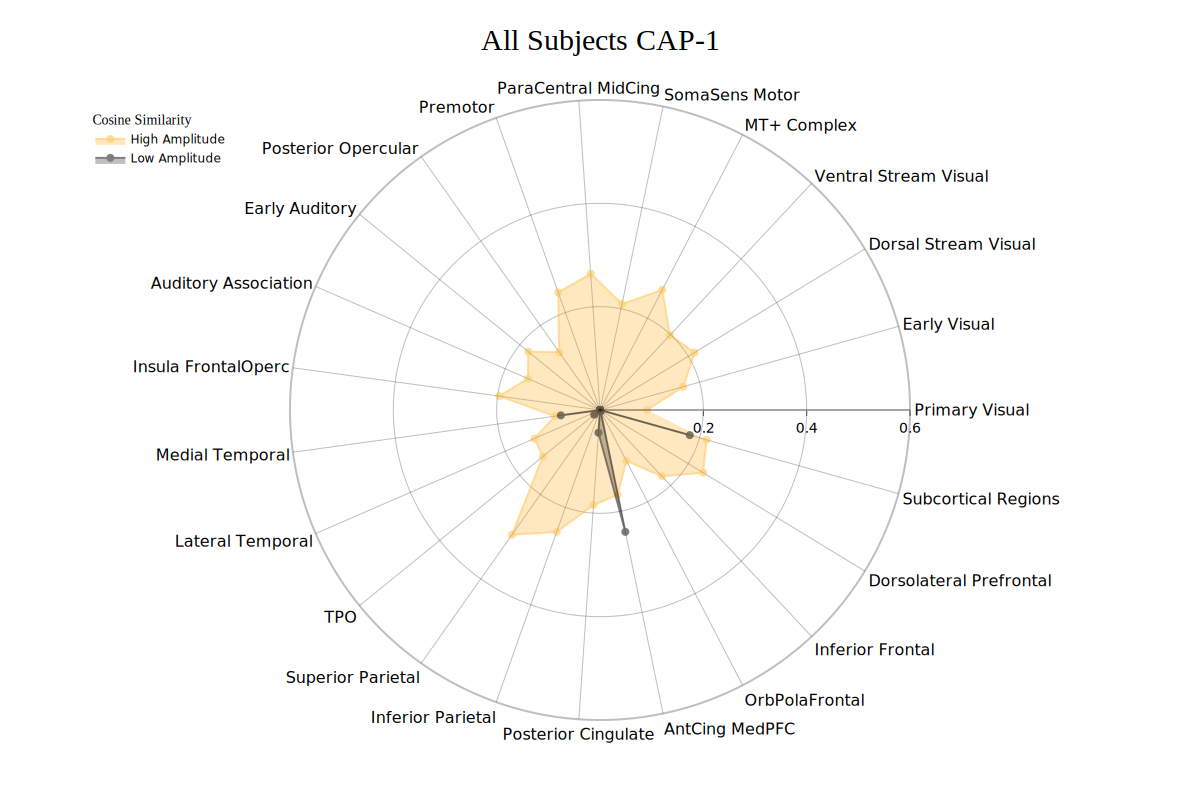

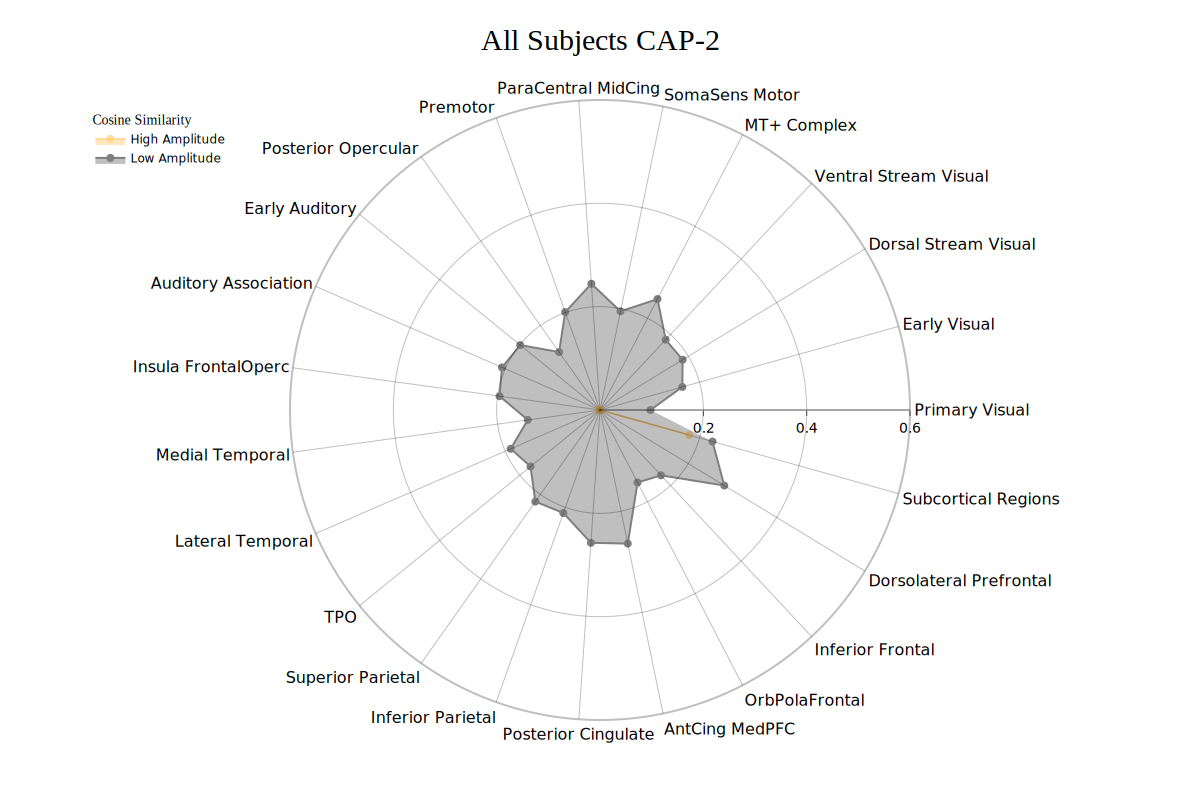

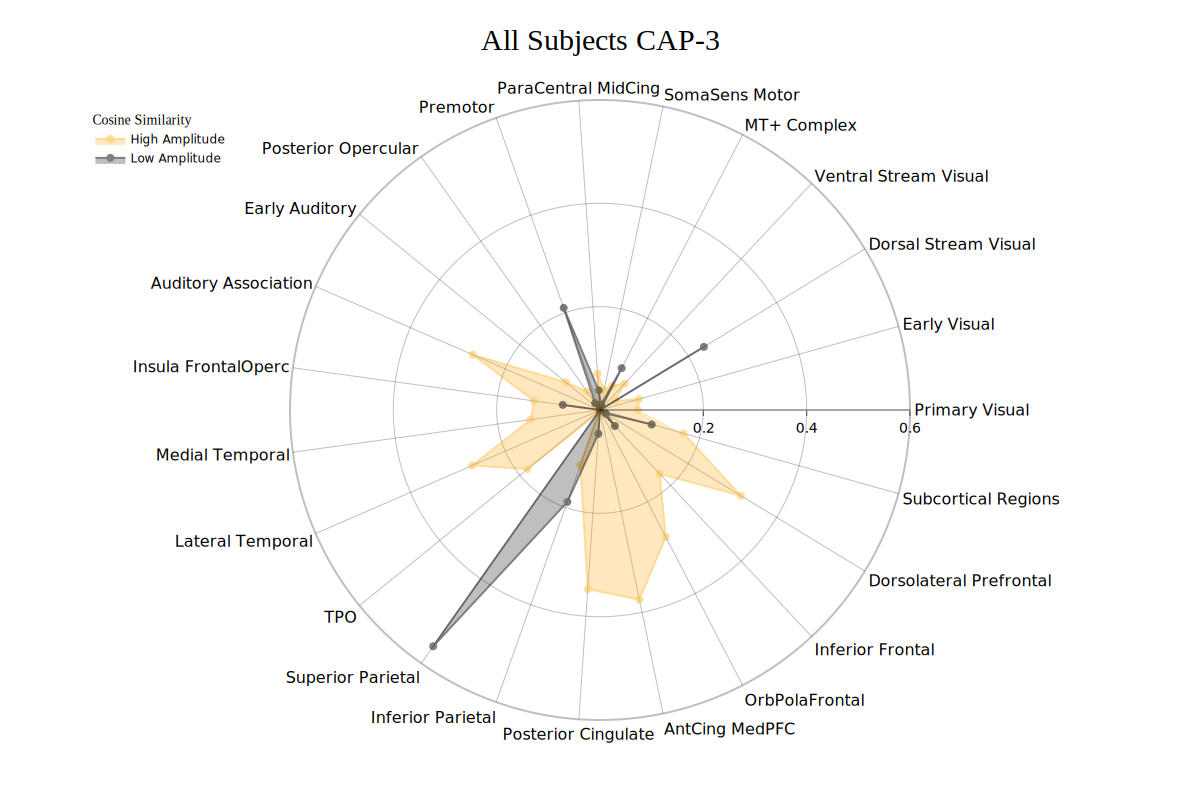

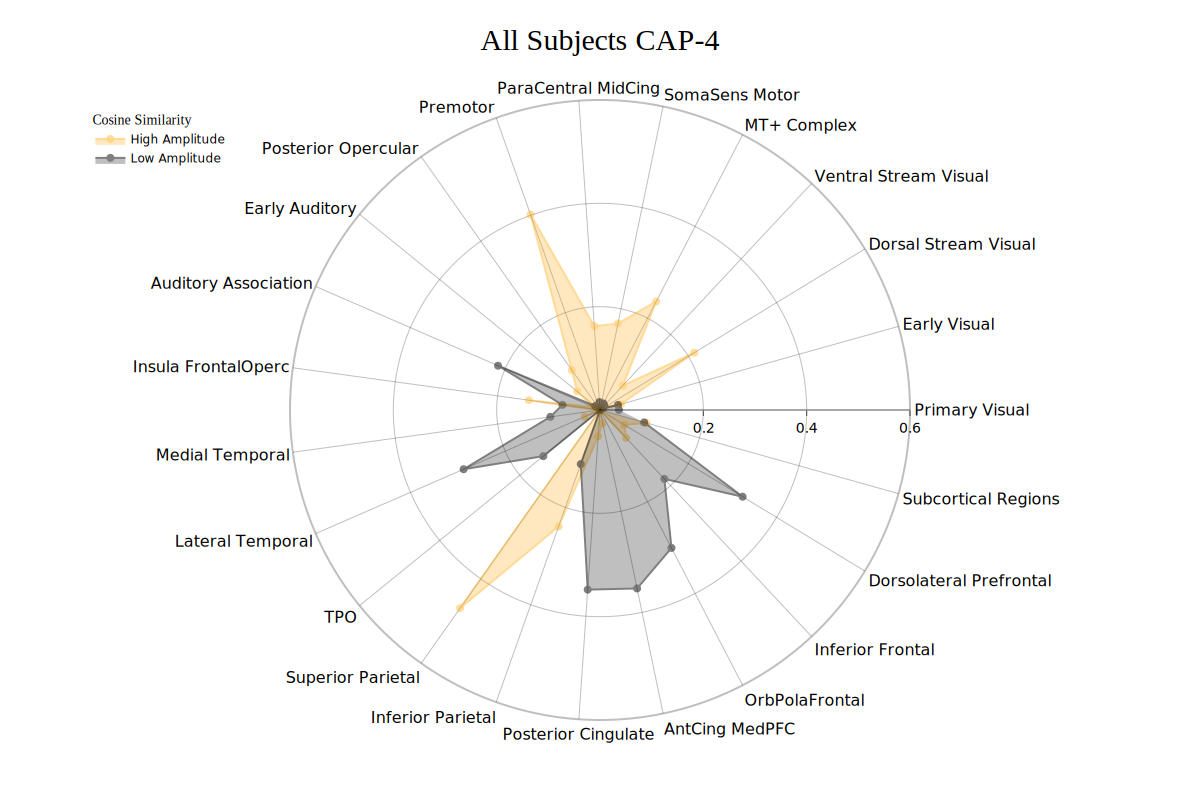

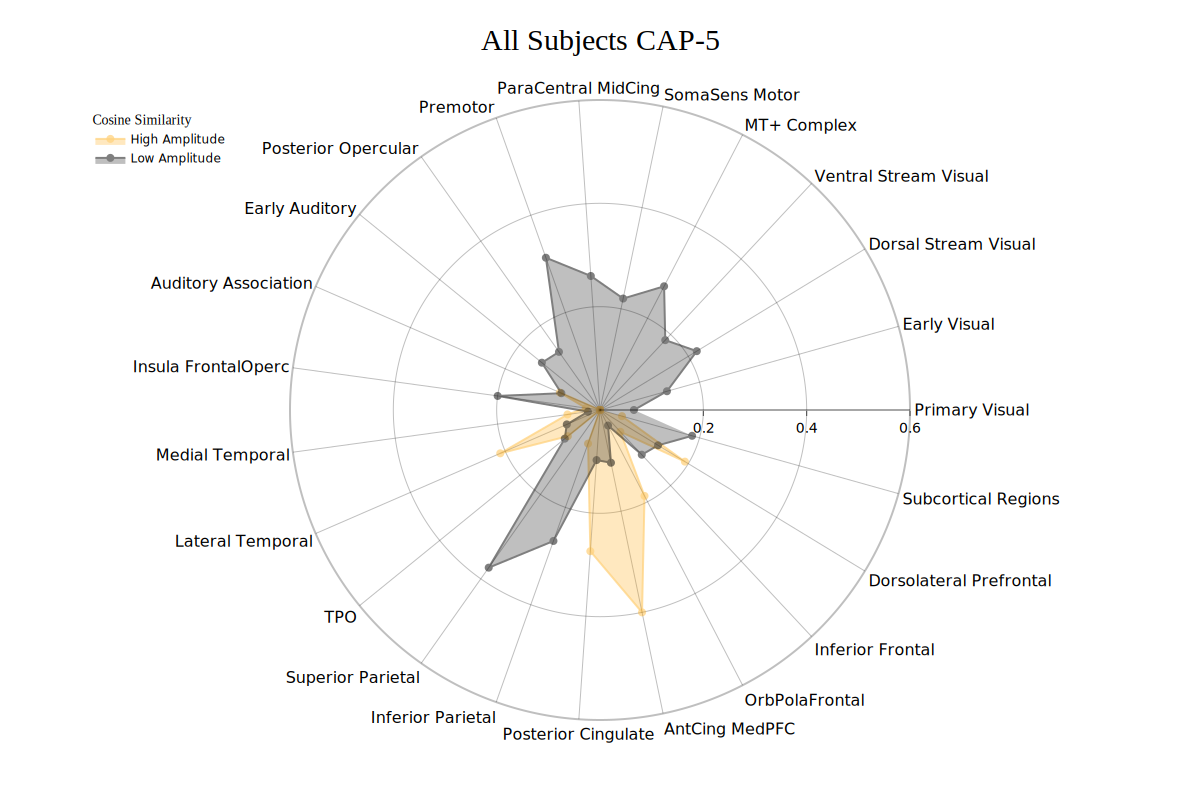

In [35]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.2, "", 0.4, "", 0.6],
}

color_discrete_map = {"High Amplitude": "rgba(255, 165, 0, 0.75)", "Low Amplitude": "black"}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    color_discrete_map=color_discrete_map,
    use_scatterpolar=True,
    output_dir=output_dir,
    as_html=True,
)

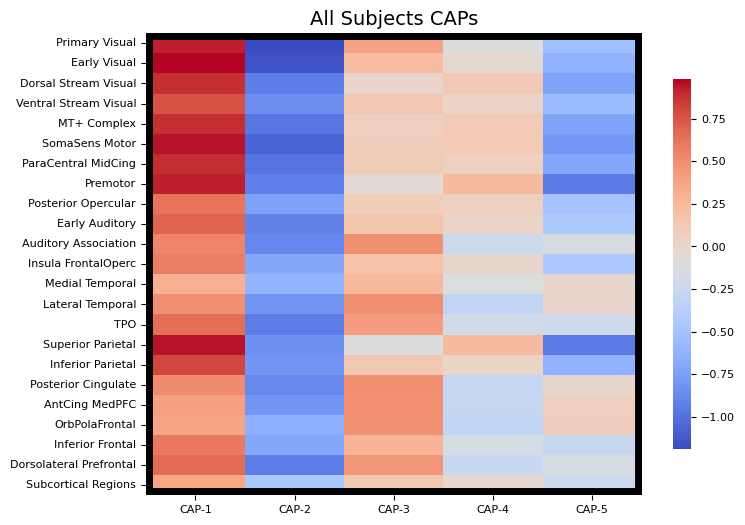

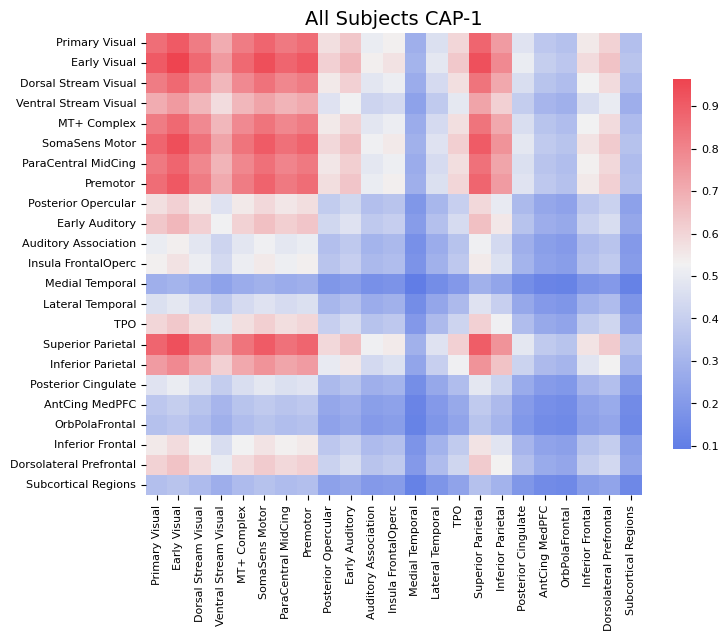

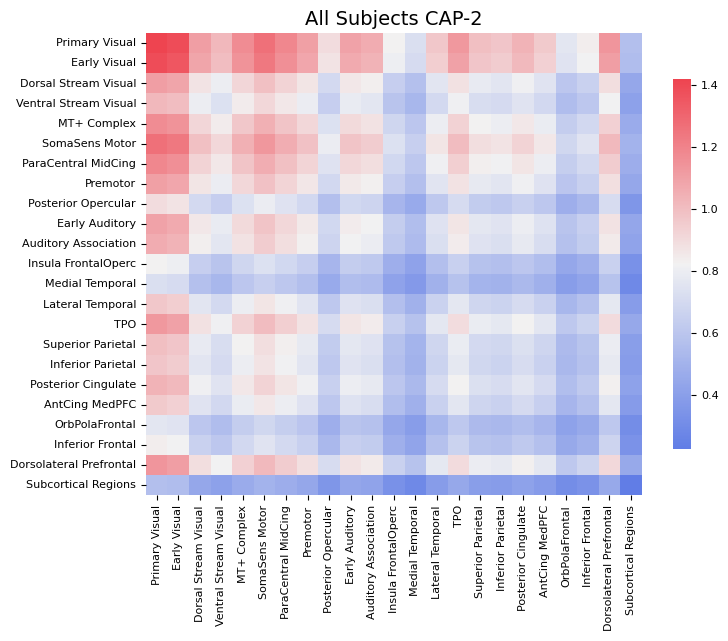

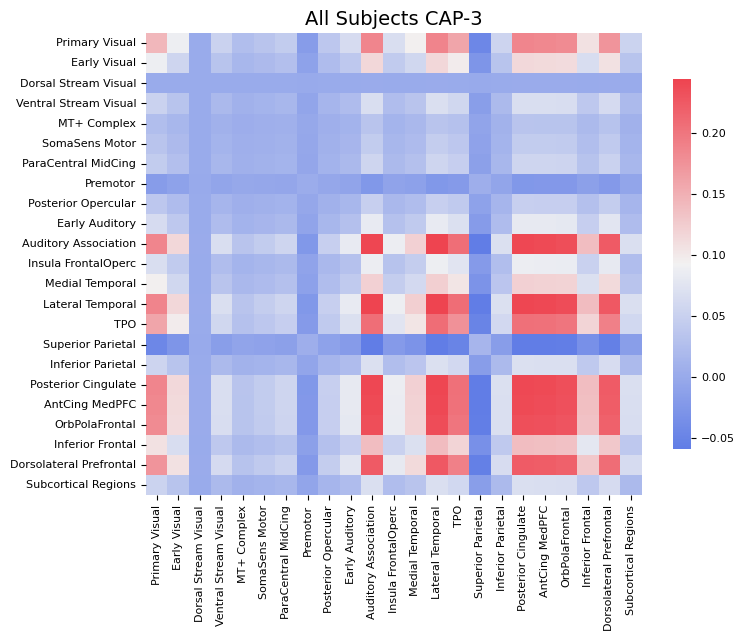

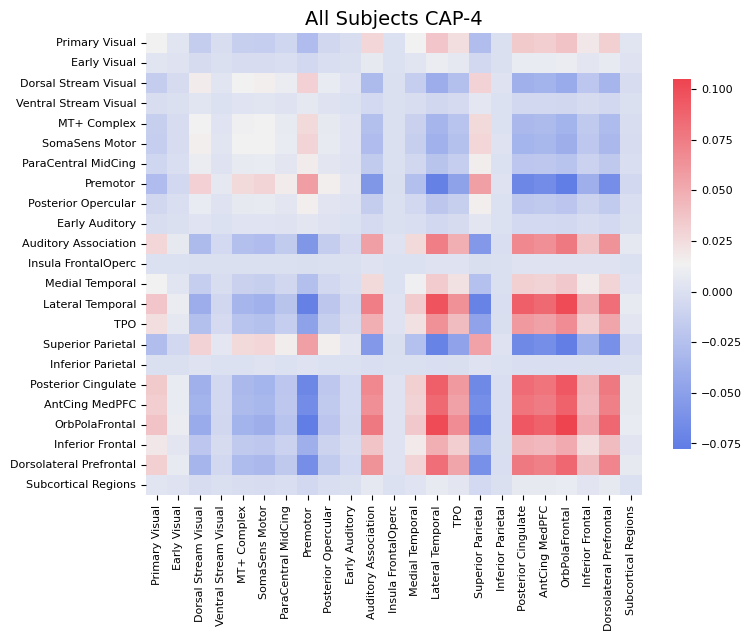

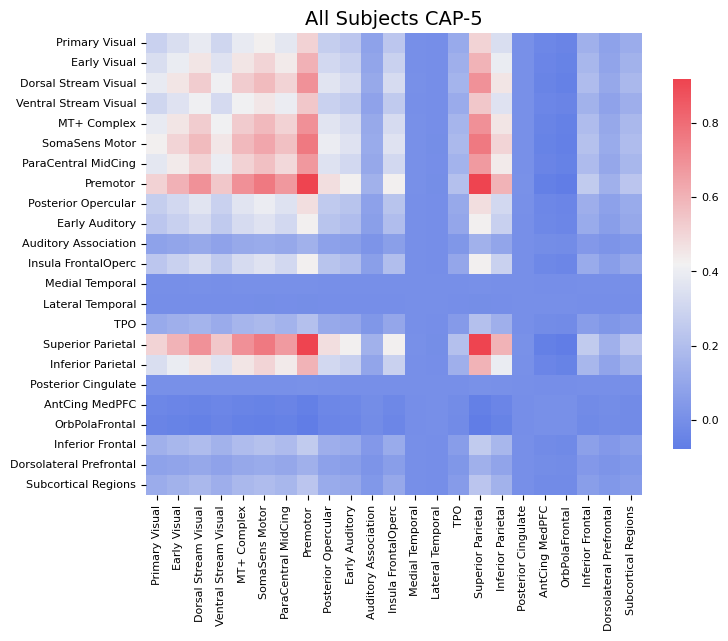

In [36]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    fontsize=14,
    tight_layout=False,
    xlabel_rotation=90,
    hspace=0.3,
    cmap=palette,
    output_dir=output_dir,
)

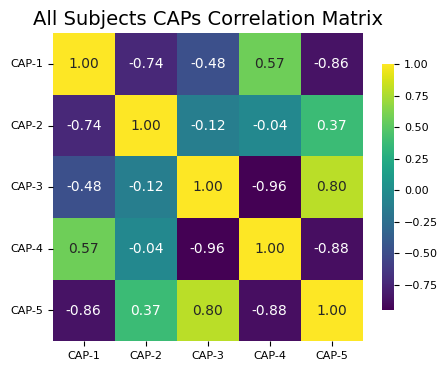

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5
0,0004,All Subjects,run-continuous,4.352941,3.769231,3.352941,3.803922,3.310345
1,0006,All Subjects,run-continuous,3.687500,3.368421,3.692308,4.269231,3.692308


In [37]:
cap_analysis.caps2corr(annot=True, cmap="viridis", fmt=".2f", figsize=(5, 4), output_dir=output_dir)

outputs = cap_analysis.calculate_metrics(
    subject_timeseries=extractor.subject_timeseries,
    tr=2,
    continuous_runs=True,
    metrics=["persistence", "transition_probability"],
    output_dir=output_dir,
)

outputs["persistence"]

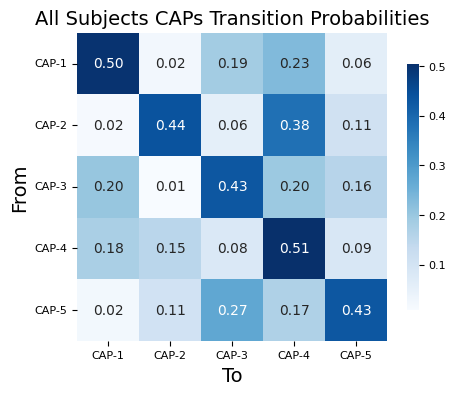

,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5
From/To,,,,,
CAP-1,0.499084,0.023706,0.187815,0.230188,0.059208
CAP-2,0.015625,0.437819,0.057079,0.381378,0.108099
CAP-3,0.204313,0.008772,0.430921,0.198830,0.157164
CAP-4,0.175820,0.151265,0.080928,0.505295,0.086692
CAP-5,0.021055,0.105718,0.273493,0.168440,0.431294


In [38]:
trans_df = transition_matrix(
    trans_dict=outputs["transition_probability"], annot=True, fmt=".2f", return_df=True, figsize=(5, 4), cmap="Blues"
)

trans_df["All Subjects"]

<font size="6">Using KNN to Fix Surface Plot Visualization Issues </font>

<font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse due to having many unassigned cortical surface voxels, there is a `knn_dict` parameter in both `self.caps2surf` and `self.caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference. **This process may take a few minutes depending on your computer**.</font>

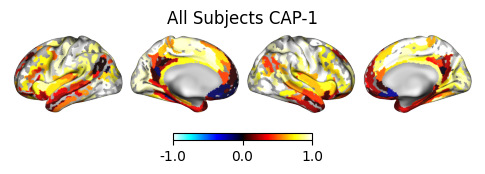

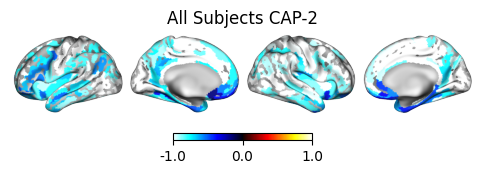

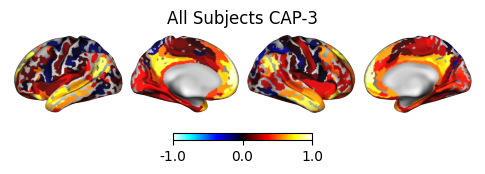

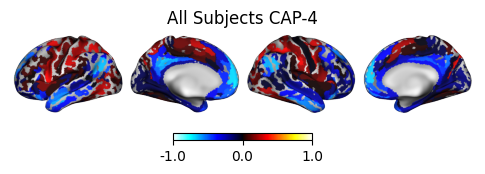

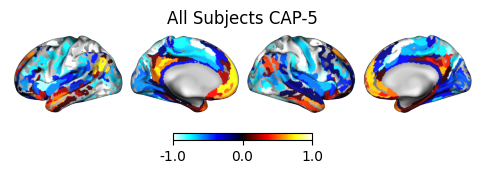

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/5 [00:00<?, ?it/s]

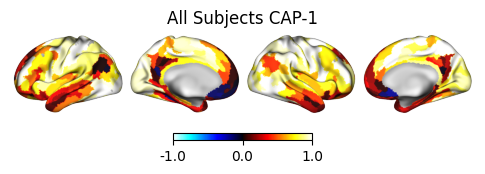

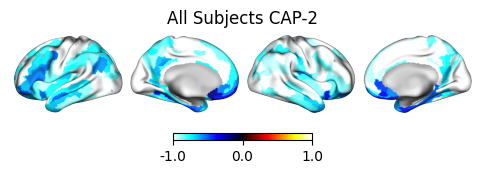

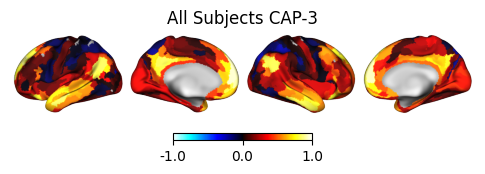

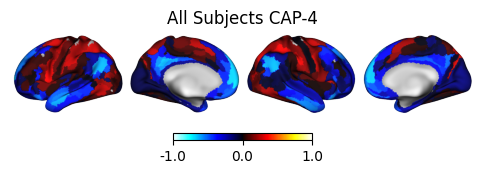

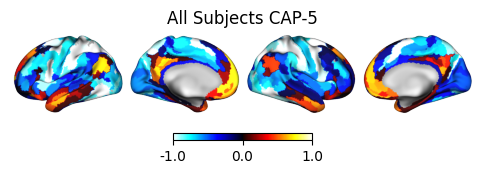

In [39]:
# Plotting with caps2surf; showing original and version using knn to reduce gaps
cap_analysis.caps2surf(size=(500, 100), layout="row", method="nearest", color_range=[-1, 1])

cap_analysis.caps2surf(
    size=(500, 100),
    layout="row",
    method="nearest",
    knn_dict={"k": 5, "reference_atlas": "Schaefer", "resolution_mm": 1},
    color_range=[-1, 1],
    save_stat_maps=True,
    output_dir=output_dir,
    progress_bar=True,
)

 <font size="3">Removes the files and directories generated in this demo.</font>

In [40]:
import shutil

shutil.rmtree("neurocaps_demo", ignore_errors=True)